# LSTM model of StockData
In this notebook we will go through a basic Long Short Term Memory (LSTM) model for time series. The notebooks does the following things:
* First load in the data. The preproccessing only consist of normalization and the creation of windows.
* Creation of the LSTM model
* Training the LSTM model
* Testing the LSTM model with 1 time step and with 1 window

## Importing libraries and loading in the data

### Import libraries

In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import matplotlib.pyplot as plt
import statsmodels.tsa.seasonal as smt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import datetime as dt
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
import plotly

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import optimizers
from keras import losses

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))
import os
os.chdir('../input/Data/Stocks/')

CalledProcessError: Command '['ls', '../input']' returned non-zero exit status 2.

### Loading in the data

In [38]:
#read data
# kernels let us navigate through the zipfile as if it were a directory

# trying to read a file of size zero will throw an error, so skip them
#filenames = [x for x in os.listdir() if x.endswith('.txt') and os.path.getsize(x) > 0]
# filenames = random.sample(filenames,1)
#print(os.listdir())
filenames = ['prk.us.txt', 'bgr.us.txt', 'jci.us.txt', 'aa.us.txt', 'fr.us.txt', 'star.us.txt', 'sons.us.txt', 'ipl_d.us.txt', 'sna.us.txt', 'utg.us.txt']
#filenames = [filenames[1]]
print(filenames)

data = []
for filename in filenames:
    df = pd.read_csv(filename, sep=',')

    label, _, _ = filename.split(sep='.')
    df['Label'] = label
    df['Date'] = pd.to_datetime(df['Date'])
    df['delta_price'] = df['Open'] - df['Close']
    df = df.drop(['Open','Close','OpenInt'], 1)
    data.append(df)
    
print(data[1].columns.values)

['prk.us.txt', 'bgr.us.txt', 'jci.us.txt', 'aa.us.txt', 'fr.us.txt', 'star.us.txt', 'sons.us.txt', 'ipl_d.us.txt', 'sna.us.txt', 'utg.us.txt']
['Date' 'High' 'Low' 'Volume' 'Label' 'delta_price']


### Plotting the data

In [3]:
r = lambda: random.randint(0,255)
traces = []

for df in data:
    clr = str(r()) + str(r()) + str(r())
#     df = df.sample(n=100, replace=True)
    df = df.sort_values('Date')
#     print(df['Label'])
    label = df['Label'].iloc[0]

    trace = plotly.graph_objs.Scattergl(
        x=df['Date'],
        y=df['delta_price'],
        mode='line',
        line=dict(
            color = clr
        )
    )
    traces.append(trace)
    
layout = plotly.graph_objs.Layout(
    title='Plot',
)
fig = plotly.graph_objs.Figure(data=traces, layout=layout)

plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot(fig, filename='dataplot')

### Creating windows and normalizing the data

In [45]:
df = data[0]
window_len = 50

df = df.drop(['Date','Label'], 1)

means = []
variances = []
for col in training_set.columns.values:
    means.append(df[col].mean())
    variances.append(df[col].var())

#Create windows for training
LSTM_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    
    for col, mean, variance in zip(list(temp_set), means, variances):
        temp_set[col] = (temp_set[col] - mean)/variance
    
    LSTM_inputs.append(temp_set)
LSTM_outputs = np.array(training_set['delta_price'][window_len:].values > 0, dtype = np.float64)

LSTM_inputs = [np.array(LSTM_input) for LSTM_input in LSTM_inputs]
LSTM_inputs = np.array(LSTM_inputs)

perm = np.random.permutation(LSTM_training_inputs.shape[0])
LSTM_inputs = LSTM_inputs[perm, :, :]
LSTM_outputs = LSTM_outputs[perm]

LSTM_training_inputs = LSTM_inputs[:-10, :, :]
LSTM_training_outputs = LSTM_outputs[:-10]
LSTM_test_inputs = LSTM_inputs[-10:, :, :]
LSTM_test_outputs = LSTM_outputs[-10:]

print(len(training_set))
print(len(training_set['delta_price'][window_len:]))
print(LSTM_inputs.shape)
print(training_set.columns.values)
print(LSTM_training_inputs.shape)
print(LSTM_training_outputs.shape)
#print(np.isnan(LSTM_training_inputs[0, 0, 3]))
#print(LSTM_training_outputs[0])
#print(np.argwhere(np.isnan(LSTM_training_inputs[:, 0, 3])))
#print(np.all(~np.isnan(LSTM_training_outputs)))

3050
(3050, 50, 4)
3100
3050
(2970, 50, 4)
['High' 'Low' 'Volume' 'delta_price']


## LSTM model definition

In [26]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.10, loss="binary_crossentropy"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    #model.add(Dropout(dropout))
    model.add(Dense(units=output_size, activation = 'sigmoid'))
    #model.add(Activation(activ_func))
    
    optimizer = optimizers.Adam(clipnorm=1)
    model.compile(loss=loss, optimizer=optimizer, metrics = ['accuracy'])
    return model

## Training of the LSTM model

In [27]:
# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
#nn_model.summary()
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=10, batch_size=32, verbose=2, shuffle=True)

Epoch 1/10
 - 7s - loss: 0.6963 - acc: 0.4737
Epoch 2/10
 - 6s - loss: 0.6931 - acc: 0.5099
Epoch 3/10
 - 6s - loss: 0.6915 - acc: 0.5299
Epoch 4/10
 - 6s - loss: 0.6906 - acc: 0.5309
Epoch 5/10
 - 6s - loss: 0.6896 - acc: 0.5322
Epoch 6/10
 - 6s - loss: 0.6890 - acc: 0.5336
Epoch 7/10
 - 6s - loss: 0.6887 - acc: 0.5382
Epoch 8/10
 - 6s - loss: 0.6885 - acc: 0.5355
Epoch 9/10
 - 6s - loss: 0.6881 - acc: 0.5375
Epoch 10/10
 - 6s - loss: 0.6878 - acc: 0.5414


### Plot of prediction of one data point ahead
As can be seen in the plot, one step prediction is not bad. The scale is a bit of, because the data is normalized. 

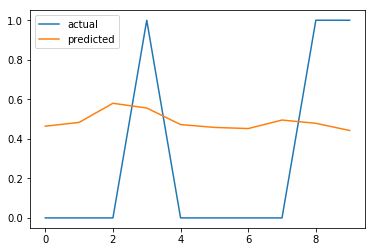

10/10 [==============================] - 0s 860us/step
The loss and accuracy are: [0.682708740234375, 0.699999988079071]


In [33]:
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
loss = nn_model.evaluate(LSTM_test_inputs, LSTM_test_outputs)
print('The loss and accuracy are: {}'.format(loss))

### Prediction of one window (10 time steps) ahead
As can be seen in the plot below, the performance quickly degrades when predicting multiple time points ahead. However compered to something like linear regression the performance is better. 

In [ ]:
#https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/lstm.py
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

predictions = predict_sequence_full(nn_model, LSTM_test_inputs, 10)

plt.plot(LSTM_test_outputs, label="actual")
plt.plot(predictions, label="predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, predictions)
print('The Mean Absolute Error is: {}'.format(MAE))

## Conclusion
LSTM's do not solve time series prediction. The prediction on one time step is not much better then the lag model. If we increase the number of time steps predicted the performance does not degrade as fast as other, more traditional, methods. However in this case we have an increase of around a factor of 4.5 in error. This grows super-linear with the number of time steps we try to predict.